# **Tarea 1: K-Nearest Neighbors**
-----

Alumna: Carlota Abarzua Contreras

Contacto: carlota.abarza@uc.cl


Fecha de Entrega: Abril 15, 2024

## **0. Instrucciones de la Tarea**

Esta tarea contempla el algoritmo de vecinos cercanos para reconstruir un mapa global.

1. Corran el código disponible en Canvas.
2. El código de ejemplo calcula la distancia Euclidiana entre dos lugares en la Tierra. Sin embargo, es más fidedigno usar una distancia geodésica para modelar el flujo de polvo en la atmósfera. La expresión

$$R \cdot \text{arc cos} \left( \sin(\phi_1) \sin(\phi_2) + \cos(\phi_1) \cos(\phi_2) \cos(\lambda_2 - \lambda_1) \right)$$

mide la distancia entre dos puntos con latitud $\phi_1$ y $\phi_2$ y longitud $\lambda_1$ y $\lambda_2$ en la superficie de una esfera con radio $R$.
3. Implementen una función para calcular la distancia geodésica y apliquen el método de vecinos cercanos con esta distancia geodésica.
4. Visualicen el resultado con la distancia geodésica.
5. Calculen la diferencia entre los dos métodos (distancia Euclidiana y geodésica) y visualicen esta diferencia.
6. Discutan por qué los resultados son distintos. En sus respuestas, a menos incluyan una discusión sobre los siguientes temas:

      a) ¿Por qué las diferencias son más grandes en una parte que en otra parte del mundo?

      b) ¿Cuál método es más fidedigno en los polos sur y norte?

      c) ¿Cuál método es más fidedigno en longitud $180^\circ$?

      d) ¿Cuáles son las diferencias entre los resultados para el Holoceno y el LGM?
      
      e) ¿Cómo elegir el número de vecinos cercanos?


Mientras pueden usar su computadora personal, el código entregado debe correr sin problemas en Google Colab.


##**1. Sobre el paper**

Titulo: Modeling Global Surface Dust Deposition Using Physics-Informed Neural Netwroks

Autores: Constanza A. Molina Catricheo, Fabrice Lambert, Julien Salomon, Elwin van't Wout


Los vientos en la atmósfera siempre han transportado polvo desde lugares secos como los desiertos a otros lugares en la Tierra. La deposición de estas partículas finas en los océanos es una fuente importante de nutrición para la fauna marina. Además, la reflexión de la luz solar por el polvo en el aire enfría la Tierra. Por tanto, para modelar el balance energético de la Tierra es esencial entender los flujos de polvo en la atmósfera. Sin embargo, existen pocos lugares en el mundo donde se puede hacer experimentos paleoclimáticos: medir la sedimentación del polvo en capas cada vez más antiguas de suelo o hielo.

Se puede emplear algoritmos de aprendizaje automatizado para reconstruir un mapa global de polvo en los últimos miles de años en base a los experimentos paleoclimáticos. Ver [este estudio reciente](https://arxiv.org/abs/2401.14372) para un estudio reciente, hecho en el marco de una tesis de magíster de una alumna de Ingeniería Matemática en la UC.

In [17]:
!pip install geodatasets

In [18]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt

## Visualize the datasets

Plot the dust deposition rate of the empirical dataset in the measurement locations and the simulated data on the global grid.

In [19]:
df_empirical_Holocene = pd.read_csv("df_empirical_Holocene.csv")
df_empirical_LGM = pd.read_csv("df_empirical_LGM.csv")

print(f"Holocene Columns:{df_empirical_Holocene.columns}")
print(f"LGM Columns:{df_empirical_LGM.columns}")

Holocene Columns:Index(['lon', 'lat', 'dep', 'log_dep', 'log_dep_norm'], dtype='object')
LGM Columns:Index(['lon', 'lat', 'dep', 'log_dep', 'log_dep_norm'], dtype='object')


In [20]:
world_map = gpd.read_file(geodatasets.get_path('naturalearth.land'))

In [21]:
def plot_dust_deposition_map(df, title, name_to_save, label_str='log_dep', measure_units='Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]', limit_bar = 3.2):
    """Generate a map plot of dust deposition based on the provided dataframe.

    Parameters:
    - df (pandas DataFrame): The dataframe containing the dust deposition data.
    - title(str): The title to be displayed on the plot.
    - name_to_save (str): The filename to save the generated map plot.
    - label_str (str, optional): The column name in the dataframe to use for labeling the data on the plot. Defaults to 'log_dep'.
    - measure_units (str, optional): The units of measurement for the dust flux. Defaults to 'Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]'.
    - limit_bar (float, optional): The limit value for the colorbar on the plot. Defaults to 3.2."""

    df_dust_geopandas = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

    fig, ax = plt.subplots(figsize=(12, 10))

    # Set limits and ticks
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-90, 91, 30))

    # Plot world map
    world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)

    # Plot the GeoDataFrame
    df_dust_geopandas.plot(column=label_str,
                           ax=ax,
                           legend=True,
                           legend_kwds={'label': measure_units, 'orientation': "horizontal"},
                           cmap='viridis',
                           vmin=-limit_bar,
                           vmax=limit_bar,
                           linewidth=0.005,
                           markersize=100)

    # Set labels and title
    ax.set(xlabel='Longitude', ylabel='Latitude', title=title)

    # Save and show the plot
    plt.savefig(f"{name_to_save}.pdf", bbox_inches='tight', dpi=600)
    plt.show()

    return


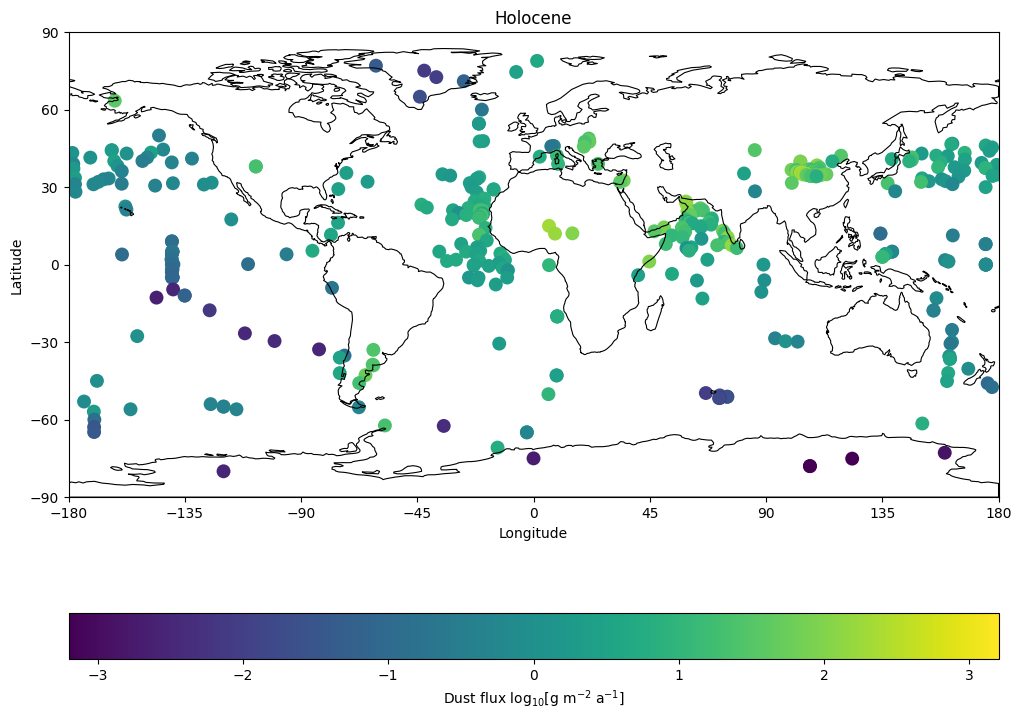

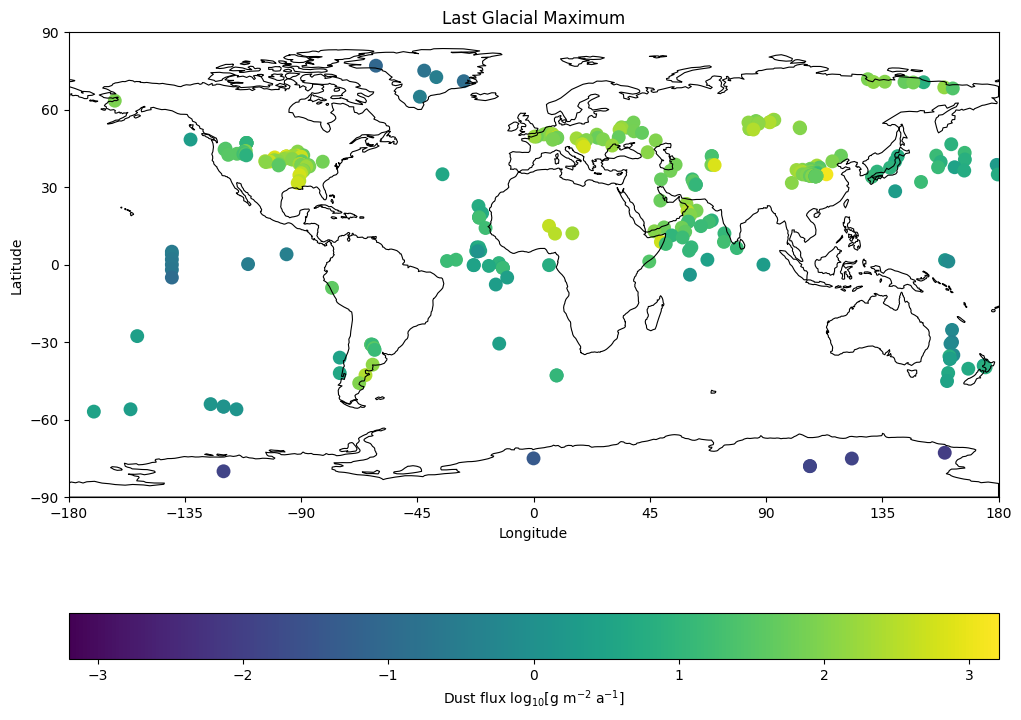

In [22]:
plot_dust_deposition_map(df=df_empirical_Holocene,
                         title='Holocene',
                         name_to_save='DATA_MAP_HOLOCENE')

plot_dust_deposition_map(df=df_empirical_LGM,
                         title='Last Glacial Maximum',
                         name_to_save='DATA_MAP_LGM')

## Create and visualize the global grid

The global grid for the predictions consists of 3-degree spacing.

In [23]:
longitude_to_predict = np.linspace(-180, 180, 121)
latitude_to_predict = np.linspace(-90, 90, 61)

xx, yy = np.meshgrid(longitude_to_predict, latitude_to_predict)
XYpairs = np.vstack([ xx.reshape(-1), yy.reshape(-1) ])
df_gpd_global_grid = gpd.GeoDataFrame(geometry=gpd.points_from_xy(XYpairs[0], XYpairs[1]))
df_global_grid = pd.DataFrame({
    'lon': df_gpd_global_grid.geometry.x,
    'lat': df_gpd_global_grid.geometry.y
})

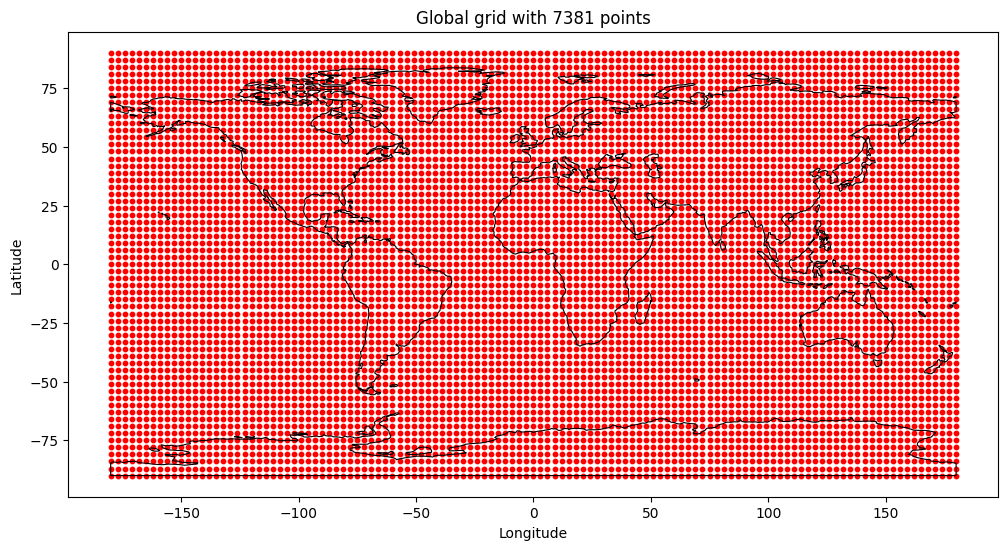

In [24]:
fig, ax = plt.subplots(figsize=(12,10))
world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)
df_gpd_global_grid.plot(ax=ax, color='red', markersize=10, marker ='o')

ax.set(xlabel='Longitude', ylabel='Latitude',
       title=f'Global grid with {df_gpd_global_grid.shape[0]} points')
plt.show()

## Analyse global deposition rate with nearest neighbours

The dust deposition rate will be estimated by averaging the values of the $k$ nearest neigbours.

In [25]:
def distance_euclidean(x, y):
    """
    Calculate the Euclidean distance between two points.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    distance = np.sqrt( (x[0] - y[0])**2 + (x[1] - y[1])**2)
    return distance

In [26]:
#Creado con Inteligencia Artificial ChatGPT
def distance_geodesic(x, y):
    """
    Calculate the geodesic distance between two points on Earth.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """

    R = 6371.0

    lat1 = np.radians(x[1])
    lon1 = np.radians(x[0])
    lat2 = np.radians(y[1])
    lon2 = np.radians(y[0])

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c

    return distance

In [27]:
def nearest_neighbour_estimation(df, x, k, dist):
    """
    Perform a k nearest neighbour estimation.

    Parameters:
    df : pandas.DataFrame
        The database.
    x : Iterable
        Location for the estimation.
    k : int
        The number of neighbours to consider.
    dist : str
        The type of distance definition.
    """

    if dist == "geodesic":
        distance_fun = distance_geodesic
    else:
        distance_fun = distance_euclidean

    distances = np.repeat(np.inf, len(df))
    for index, row in df.iterrows():
        distances[index] = distance_fun(x, (row["lon"], row["lat"]))

    sorted_indices = np.argsort(distances)
    nearest_points = sorted_indices[:k]

    values_neighbours = df.loc[nearest_points, "log_dep"]
    estimation = np.average(values_neighbours)

    return estimation

In [28]:
# Choose the number of neighbours to include in the estimation
n_neighbours = 5

In [29]:
#Running Time: 5 minutes
estimations_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_lgm = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='euclidean')
    estimations_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='euclidean')

df_global_grid["est_hol"] = estimations_holocene
df_global_grid["est_lgm"] = estimations_lgm

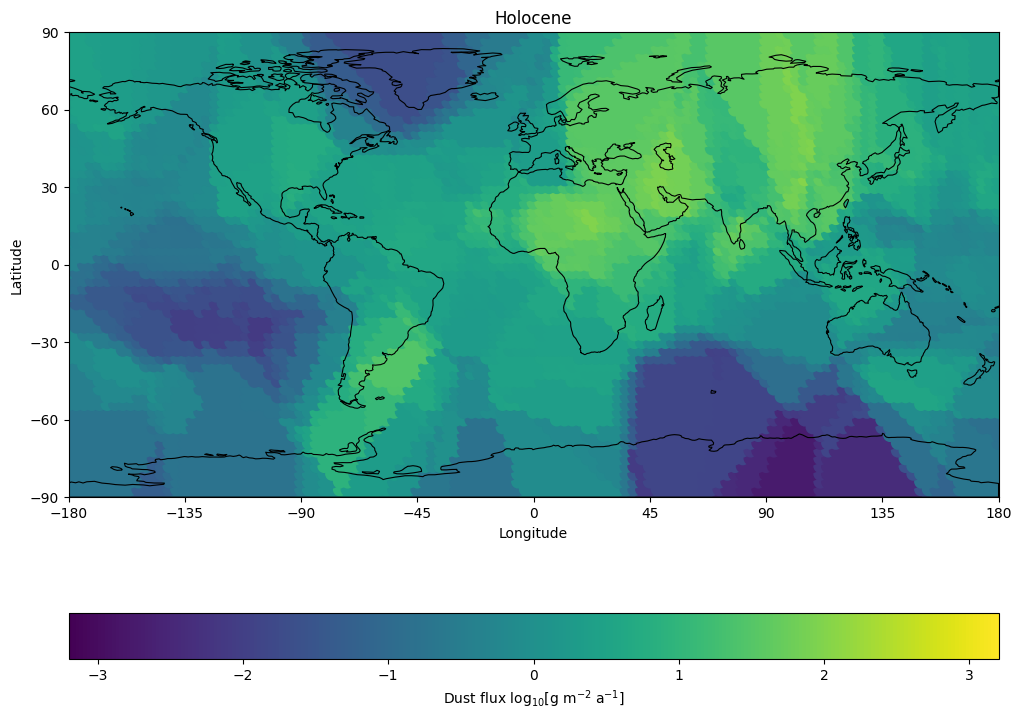

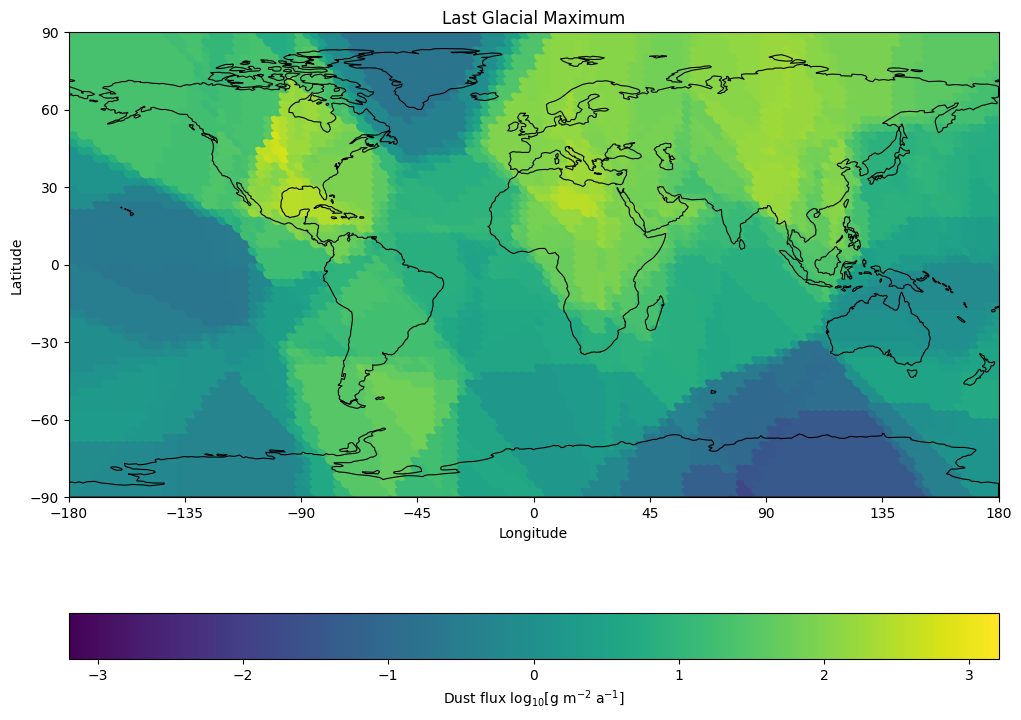

In [30]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm')

In [31]:
# Running Time: 5 minutes

estimations_holocene_geod = np.repeat(np.inf, len(df_global_grid))
estimations_lgm_geod = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene_geod[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='geodesic')
    estimations_lgm_geod[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='geodesic')

df_global_grid["est_hol_geod"] = estimations_holocene_geod
df_global_grid["est_lgm_geod"] = estimations_lgm_geod

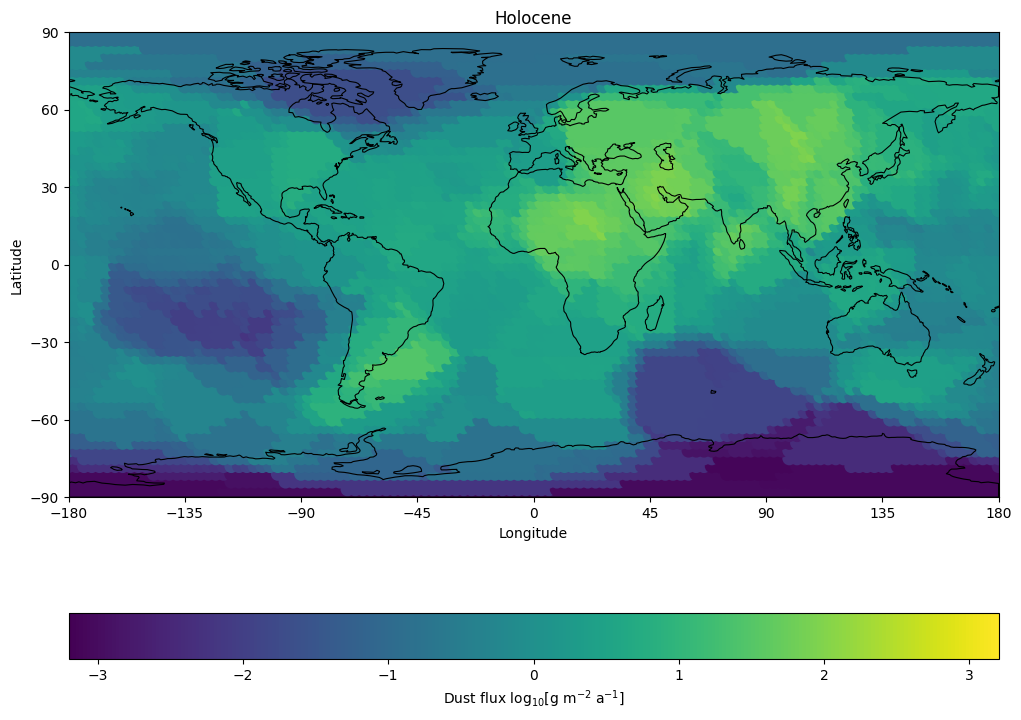

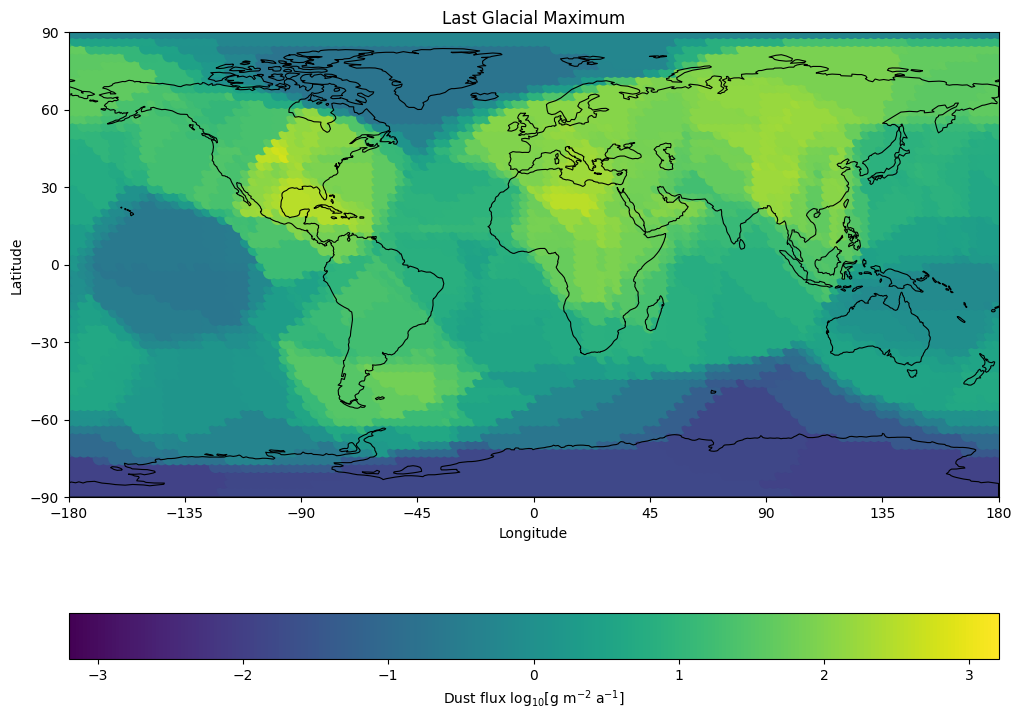

In [32]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE_GEOD',
                         label_str='est_hol_geod')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM_GEOD',
                         label_str='est_lgm_geod')

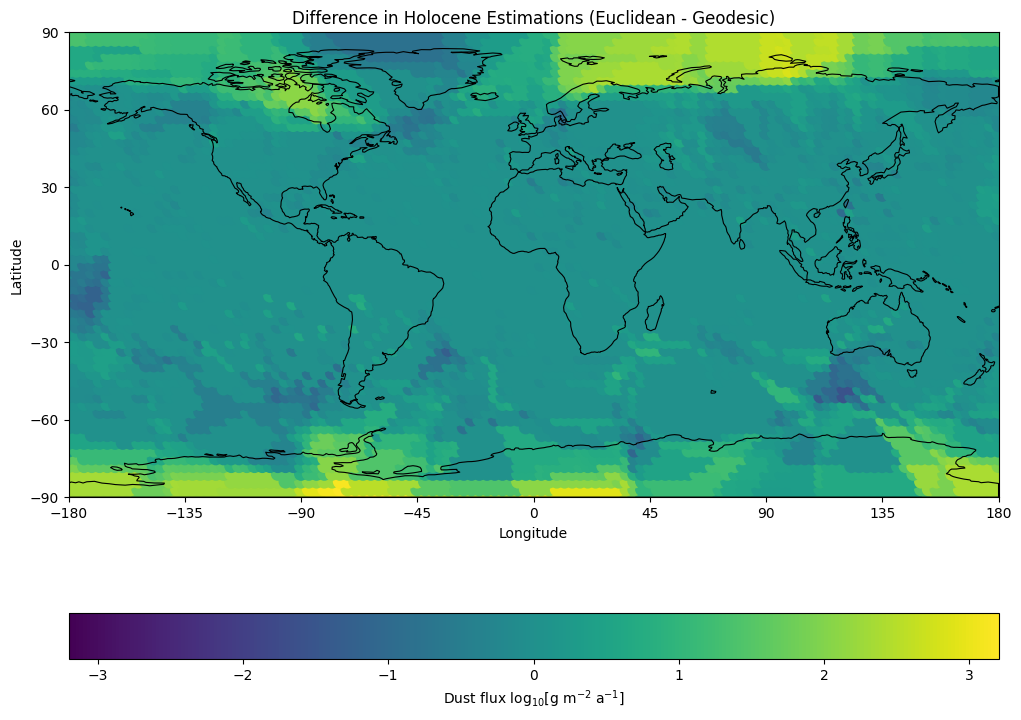

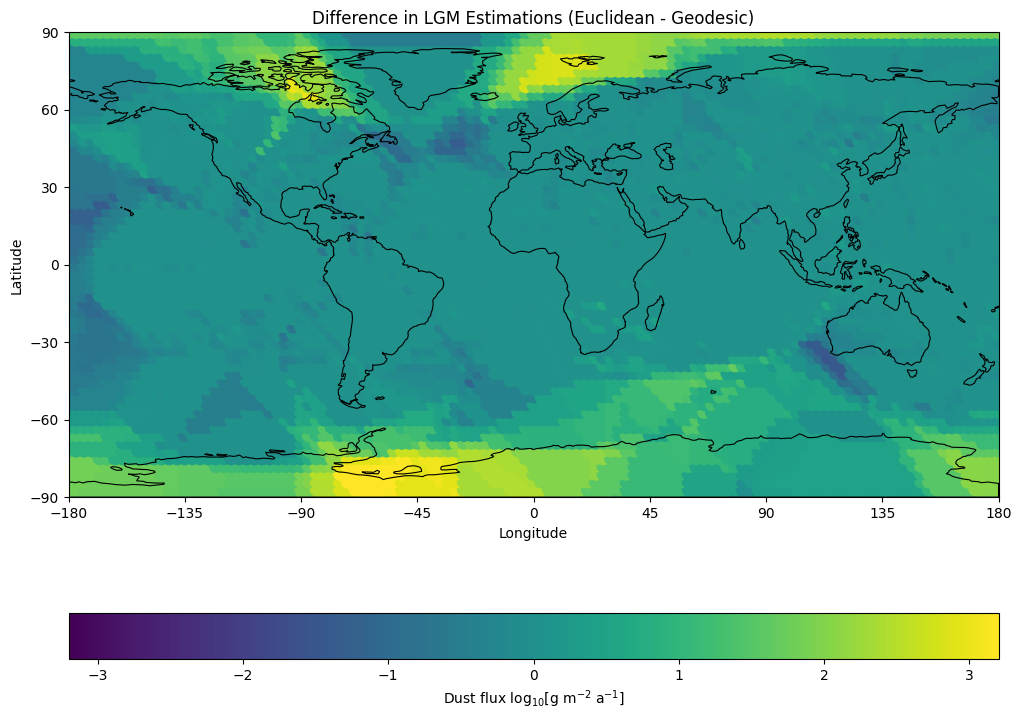

In [33]:
df_global_grid['diff_holocene'] = df_global_grid['est_hol'] - df_global_grid['est_hol_geod']
df_global_grid['diff_lgm'] = df_global_grid['est_lgm'] - df_global_grid['est_lgm_geod']


plot_dust_deposition_map(df=df_global_grid,
                         title='Difference in Holocene Estimations (Euclidean - Geodesic)',
                         name_to_save='DIFFERENCE_MAP_HOLOCENE',
                         label_str='diff_holocene')

plot_dust_deposition_map(df=df_global_grid,
                         title='Difference in LGM Estimations (Euclidean - Geodesic)',
                         name_to_save='DIFFERENCE_MAP_LGM',
                         label_str='diff_lgm')

### a) ¿Por qué las diferencias son más grandes en una parte que en otra parte del mundo?

Las diferencias entre las distancias euclidianas y geodésicas pueden variar significativamente dependiendo de la topografía y la distribución de los puntos de los datasets entregados en distintas regiones del mundo. Por ejemplo, en áreas con relieve complejo o una distribución irregular de datos, es más probable que las diferencias entre estas distancias sean más notables. Esto se debe a que la distancia euclidiana no consideran la curvatura de la Tierra, lo que resulta en diferencias más amplias en regiones donde la curvatura es más evidente, en este caso, los polos norte y sur.

### b) ¿Cuál método es más fidedigno en los polos sur y norte?

La distancia geodésica es más confiable en los polos sur y norte debido a que tiene en cuenta la curvatura de la Tierra. En estas regiones, la curvatura es más pronunciada y la distancia euclidiana puede subestimar significativamente las distancias reales. De esta manera, podemos apreciar en el grafico de deposiciones utilizando distancia geodesica que el area de los polos hay zonas que no capto el grafico con distancia euclidiana.

### c) ¿Cuál método es más fidedigno en longitud $180^∘$?
Igualmente que la respuesta anterior, la distancia geodésica es el método más fidedigno, inclusive en longitud $180^∘$, donde convergen los meridianos opuestos, ya que, considera la curvatura de la Tierra.


### d) ¿Cuáles son las diferencias entre los resultados para el Holoceno y el LGM?

En el análisis de las diferencias entre los resultados para el Holoceno y el LGM, se observa que en el primero hay un mayor flujo de polvo representado por tonos azules en los polos, mientras que en el LGM se destaca un flujo más notable, representado en tonos amarillos, en los continentes, principalmente en Asia y América del Norte. Sin embargo, al examinar el gráfico de las diferencias en ambos periodos, se puede concluir que la distancia geodésica proporciona una mejor estimación para estas áreas, como se evidencia en las zonas coloreadas en amarillo y en tonos morados o azules.
### e) ¿Cómo elegir el número de vecinos cercanos?

a selección del número de vecinos cercanos puede tener un impacto significativo en la precisión de las estimaciones. Un número bajo de vecinos cercanos puede generar estimaciones sesgadas, mientras que un número alto puede aumentar considerablemente el tiempo de cálculo y la complejidad del modelo. En este caso, para determinar el número óptimo de vecinos, examiné el primer gráfico y observé cómo se podrían dividir los puntos en sectores o "vecindades" de manera óptima. Identifiqué entre 4 y 5 clusters distintos. Luego de evaluar las opciones, decidí utilizar k = 5, a pesar de que implicaba una mayor complejidad computacional, ya que permitía una mayor precisión en las estimaciones.